In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Using newly preprocessed subjects

import pickle

metadictname = '/content/drive/MyDrive/Tulane/Research/PNC/PNC_agesexwrat.pkl'
alltsname = '/content/drive/MyDrive/Tulane/Research/PNC/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [3]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [4]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X[0:1]]
# ts = [tsmod/np.linalg.norm(tsmod, axis=-1, keepdims=True) for tsmod in ts]
print(ts[0].shape)

(847, 34716)


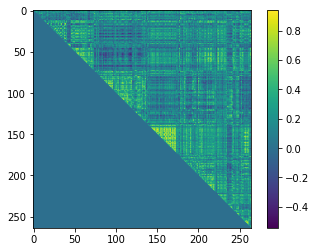

In [5]:
import matplotlib.pyplot as plt

def flat_fc_to_img(fc):
    img = np.zeros((264,264))
    a,b = np.triu_indices(264, 1)
    img[a,b] = fc
    return img

plt.imshow(flat_fc_to_img(ts[0][0]))
plt.colorbar()
plt.show()

In [ ]:
import torch
import pickle

x = torch.from_numpy(ps[0]).float().cuda()
xnp = ps[0]
newtsnp = None

with open('/content/drive/MyDrive/Tulane/Research/Work/BadAutoencoder/restbadauto.pkl', 'rb') as f:
#     pickle.dump(newtsnp, f)
    newtsnp = pickle.load(f)
    
res = x-torch.from_numpy(newtsnp).float().cuda()
print(res.shape)

print('Complete')

torch.Size([847, 264, 124])
Complete


In [6]:
!pip install ksvd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
print(ts[0].shape)

(847, 34716)


In [125]:
from ksvd import ApproximateKSVD

aksvd = ApproximateKSVD(n_components=1000, transform_n_nonzero_coefs=1000, max_iter=1)
dictionary = aksvd.fit(ts[0][:400]).components_
gamma = aksvd.transform(ts[0])

print(dictionary.shape)
print(gamma.shape)

(1000, 34716)
(847, 1000)


In [126]:
with open('/content/drive/MyDrive/Tulane/Research/Work/BadAutoencoder/ksvdrest_1000_1_split.pkl', 'wb') as f:
    pickle.dump({'dict': dictionary, 'gamma': gamma}, f)

print('Complete')

Complete


In [119]:
with open('/content/drive/MyDrive/Tulane/Research/Work/BadAutoencoder/ksvdrest_800_1_split.pkl', 'rb') as f:
    A = pickle.load(f)

print(list(A.keys()))
gamma = A['gamma']
print('Complete')

['dict', 'gamma']
Complete


In [18]:
!git clone https://github.com/aorliche/LatentSimilarity.git

Cloning into 'LatentSimilarity'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 38 (delta 15), reused 30 (delta 9), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [19]:
import sys

sys.path.append('LatentSimilarity')

from latsim.latsim import LatSim

print('Complete')

Complete


In [219]:
import torch
import torch.nn as nn

mseLoss = nn.MSELoss()

ntrain = 600
x = torch.from_numpy(gamma).unsqueeze(1).float().cuda()
xtr = x[:ntrain]
xt = x[ntrain:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:ntrain]
yt = y_t[ntrain:]

sim = LatSim(1, x, dp=0, edp=0.1, wInit=1e-4, dim=1, temp=1)
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

nEpochs = 1000
pPeriod = 50

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xtr, [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    z, _ = sim.getLatentsAndEdges(xtr[:,0], 0, 0)
    sloss = 0*torch.sum(torch.abs(z))
    (sloss+loss).backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} {sloss} lr: {sched._last_lr}')
        
yhat = sim(x, [y_t])[0][0][ntrain:]
loss = mseLoss(yhat, yt)**0.5
print(loss)

0 40.06600389318543 0.0 lr: [0.0001]
50 39.97327293114895 0.0 lr: [9.5e-05]
100 39.66134257342485 0.0 lr: [9.5e-05]
150 39.134544500251785 0.0 lr: [9.5e-05]
200 38.60189533225263 0.0 lr: [9.5e-05]
250 38.20206734221003 0.0 lr: [9.5e-05]
300 37.94041026986019 0.0 lr: [9.5e-05]
350 37.65228356962978 0.0 lr: [9.5e-05]
400 37.366510454090104 0.0 lr: [9.025e-05]
450 37.15055774049277 0.0 lr: [9.025e-05]
500 36.927473588969804 0.0 lr: [9.025e-05]
550 36.788057927195446 0.0 lr: [9.025e-05]
600 36.61305099182104 0.0 lr: [9.025e-05]
650 36.44314452956996 0.0 lr: [8.573749999999999e-05]
700 36.30680153759933 0.0 lr: [8.573749999999999e-05]
750 36.22495936041975 0.0 lr: [8.145062499999998e-05]
800 36.116625597240535 0.0 lr: [7.350918906249998e-05]
850 36.0196869320055 0.0 lr: [6.983372960937497e-05]
900 35.96954244077116 0.0 lr: [5.987369392383786e-05]
950 35.87667917183023 0.0 lr: [5.4036008766263664e-05]
999 35.85495955931341 0.0 lr: [4.6329123015975305e-05]
tensor(36.3231, device='cuda:0', gra

In [218]:
ntrain = 600
x = torch.from_numpy(gamma)
x = torch.cat([torch.ones(x.shape[0],1), x], dim=1)
x = x.float().cuda()
xtr = x[:ntrain]
xt = x[ntrain:]
w, _, _, _ = torch.linalg.lstsq(xtr, ytr)

print(mseLoss(xt@w, yt)**0.5)

tensor(37.0832, device='cuda:0')


In [217]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(ts[0])
gamma = pca.transform(ts[0])

print(gamma.shape)

(847, 2)


In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F

mseLoss = nn.MSELoss()

class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,100).float().cuda()
        self.l1 = nn.Linear(100,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        return self.l1(y).squeeze()
    
ntrain = 600
x = torch.from_numpy(gamma).float().cuda()
xtr = x[:ntrain]
xt = x[ntrain:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:ntrain]
yt = y_t[ntrain:]

mlp = MLP(x.shape[-1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

nEpochs = 10000
pPeriod = 500
lmbda = 1e1

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xtr)
    loss = mseLoss(yhat, ytr)
    sloss = lmbda*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    (sloss+loss).backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} {float(sloss)} lr: {sched._last_lr}')
        
yhat = mlp(xt)
loss = mseLoss(yhat, yt)**0.5
print(loss)

0 184.02721435972452 987.1329345703125 lr: [0.001]
500 82.80003443915346 1321.8214111328125 lr: [0.001]
1000 76.72627890755552 1278.3109130859375 lr: [0.001]
1500 73.64907023768188 1223.1533203125 lr: [0.001]
2000 65.55698484310234 1204.70458984375 lr: [0.001]
2500 52.495505294947634 1161.0869140625 lr: [0.001]
3000 41.067623289121414 1079.4840087890625 lr: [0.001]
3500 36.43994551184524 969.24365234375 lr: [0.001]
4000 35.44983836407526 865.0372314453125 lr: [0.001]
4500 35.28992122460834 772.919677734375 lr: [0.0005987369392383785]
5000 35.26005508184864 744.8887939453125 lr: [9.446824413773756e-05]
5500 35.253703470677195 741.1658935546875 lr: [1.0408804957535729e-05]
6000 35.25242054521753 740.7340087890625 lr: [1.915489806775087e-06]
6500 35.25145615620456 740.5231323242188 lr: [1.915489806775087e-06]
7000 35.25014890815179 740.30078125 lr: [1.915489806775087e-06]
7500 35.24870308729014 740.0614013671875 lr: [1.915489806775087e-06]
8000 35.24697495054097 739.810791015625 lr: [1.91

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

x = [[torch.from_numpy(pp).float().cuda() for pp in para] for para in p]
x = torch.stack([torch.stack(para) for para in x], dim=1)
xtr = x[:600]
xt = x[600:]

print(x.shape)
print(xtr.shape)
print(xt.shape)

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(y_t.shape)
print(ytr.shape)
print(yt.shape)

NameError: ignored

In [ ]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

d = int(264*263/2)

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.l0 = nn.Linear(d,1000).float().cuda()
        self.l1 = nn.Linear(1000,200).float().cuda()
        self.l2 = nn.Linear(200,1000).float().cuda()
        self.l3 = nn.Linear(1000,d).float().cuda()

    def encode(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y)
        return y

    def decode(self, x):
        y = F.relu(self.l2(x))
        y = self.l3(y)
        return y

    def forward(self, x):
        y = self.encode(x)
        y = self.decode(y)
        return y

nEpochs = 5000
pPeriod = 100
nRanks = 300

mseLoss = nn.MSELoss()
    
ae = AE()

optim = torch.optim.Adam(ae.parameters(), lr=5e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)
    
for epoch in range(nEpochs):
    for i in range(1):
        optim.zero_grad()
        xhat = ae(xtr[:,i])
        xloss = mseLoss(xhat, xtr[:,i])
        xloss.backward()
        optim.step()
        sched.step(xloss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {float(xloss**0.5)} lr: {sched._last_lr}')

print('Complete')

0 recon: 0.4049125015735626 lr: [0.0005]
100 recon: 0.18066608905792236 lr: [0.0005]
200 recon: 0.1728486269712448 lr: [0.000475]
300 recon: 0.16675755381584167 lr: [0.000475]
400 recon: 0.16606606543064117 lr: [0.00040725312499999993]
500 recon: 0.16195127367973328 lr: [0.0003675459453124999]
600 recon: 0.16111527383327484 lr: [0.0003151247048623045]
700 recon: 0.15673120319843292 lr: [0.00028440004613822977]
800 recon: 0.15557898581027985 lr: [0.00025667104163975234]
900 recon: 0.15362101793289185 lr: [0.00022006333432588265]
1000 recon: 0.15228596329689026 lr: [0.0001886768012676536]
1100 recon: 0.15089523792266846 lr: [0.00016176677248685447]
1200 recon: 0.14949952065944672 lr: [0.00013869478656091682]
1300 recon: 0.14812017977237701 lr: [0.0001251720448712274]
1400 recon: 0.14706872403621674 lr: [0.00011296777049628272]
1500 recon: 0.1456255316734314 lr: [0.00010731938197146858]
1600 recon: 0.1445174366235733 lr: [0.00010195341287289515]
1700 recon: 0.14315401017665863 lr: [9.2012

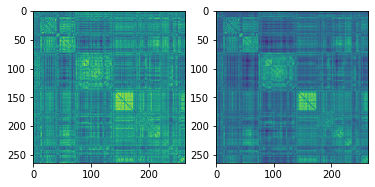

In [ ]:
def flat_fc_to_full(x):
    x = x.detach().cpu().numpy()
    p = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    p[a,b] = x
    p = p.T+p
    return p

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].imshow(flat_fc_to_full(xtr[0,0]))
ax[1].imshow(flat_fc_to_full(xhat[0]))
plt.show()


In [ ]:
# Try 

xtrae = ae.encode(xtr[:,0])
xtae = ae.encode(xt[:,0])

print(xtae.shape)

w, _, _, _ = torch.linalg.lstsq(xtrae, ytr)
yhattr = xtrae@w
yhat = xtae@w

print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhat, yt)**0.5)

torch.Size([247, 200])
tensor(23.1527, device='cuda:0', grad_fn=<PowBackward0>)
tensor(122.9398, device='cuda:0', grad_fn=<PowBackward0>)
